# odeint examples

Code for *Modeling and Simulation in Python*

by Allen B. Downey, available from http://greenteapress.com

Copyright 2017 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpy as np
from scipy.integrate import odeint

from pint import UnitRegistry
UNITS = UnitRegistry()

## Basic example using odeint without units

Here is a slope function for a spring mass system where the spring force depends on positive and the friction force depends on velocity.

In [2]:
def slope_func(Y, t):
    y1, y2 = Y
    y1p = y2
    y2p = -(y1 + y2)
    return y1p, y2p

Starting with initial position 1 and velocity 0.

In [3]:
y_init = [1, 0]
y_init

[1, 0]

If we evaluate the slope function with the starting conditions, we get velocity toward 0.

In [4]:
slope_func(y_init, 0)

(0, -1)

Here's the sequence of times we would like to integrate over.

In [5]:
ts = np.arange(0, 15.0, 0.1)
type(ts)

numpy.ndarray

And here's how we call `odeint`:

In [6]:
asol = odeint(slope_func, y_init, ts)

The result is a matrix, but we can assign the columns to variables.

In [7]:
position, velocity = asol.transpose()

And plot position as a function of time.

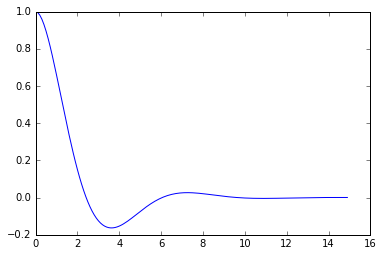

In [8]:
plt.figure()
plt.plot(ts, position, 'b');

Here's velocity as a function of time.

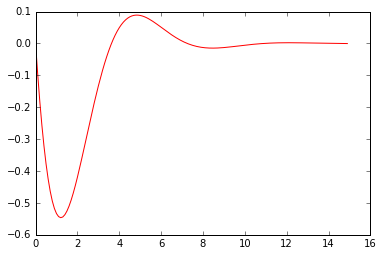

In [9]:
plt.figure()
plt.plot(ts, velocity, 'r');

## Same example, now with units

I'll import Pint and instantiate a registry.

In [10]:
import pint
UNITS = pint.UnitRegistry()

For reasons we'll see later, I'm going to monkey patch the Unit and Quantity classes so they don't cache dimensionality information.

In [11]:
@property
def dimensionality(self):
    """Unit's dimensionality (e.g. {length: 1, time: -1})
    """
    dim = self._REGISTRY._get_dimensionality(self._units)
    return dim

pint.unit._Unit.dimensionality = dimensionality
pint.quantity._Quantity.dimensionality = dimensionality

Here are the units we'll use for this problem.

In [12]:
kg = UNITS.kilogram
s = UNITS.second
N = UNITS.newton
m = UNITS.meter

And here are their dimensions.

In [13]:
UNITS.kilogram.dimensionality, UNITS.second.dimensionality, UNITS.newton.dimensionality, UNITS.meter.dimensionality

(<UnitsContainer({'[mass]': 1.0})>,
 <UnitsContainer({'[time]': 1.0})>,
 <UnitsContainer({'[length]': 1.0, '[mass]': 1.0, '[time]': -2.0})>,
 <UnitsContainer({'[length]': 1.0})>)

Now I'll define the parameters of the problem with units.

In [14]:
mass = 1 * (kg)
k = 1 * (N / m)            # spring constant
c = 1 * (N / (m/s))        # dynamic friction

# times
ts = np.arange(0, 15.0, 0.1) * s

And here are their dimensions:

In [15]:
mass.dimensionality, k.dimensionality, c.dimensionality, ts.dimensionality

(<UnitsContainer({'[mass]': 1.0})>,
 <UnitsContainer({'[mass]': 1.0, '[time]': -2.0})>,
 <UnitsContainer({'[mass]': 1.0, '[time]': -1.0})>,
 <UnitsContainer({'[time]': 1.0})>)

Here's a version of the slope function with the parameters.

In [16]:
def slope_func(Y, t):
    y1, y2 = Y
    y1p = y2
    y2p = -(c*y2 + k*y1) / mass
    return y1p, y2p

And the initial conditions with units.

In [17]:
y_init = [1 * (m), 0 * (m/s)]
y_init

[<Quantity(1, 'meter')>, <Quantity(0, 'meter / second')>]

Now when we call the slope function the results have the right units.

In [18]:
slope_func(y_init, 0)

(<Quantity(0, 'meter / second')>, <Quantity(-1.0, 'newton / kilogram')>)

But when we call `odeint`, we get an error, presumably because it was not expecting things with units.

In [19]:
asol = odeint(slope_func, y_init, ts)

ValueError: setting an array element with a sequence.

## Turning off the units temporarily

We can make everything behave as if it is dimensionless by replacing `UNITS._get_dimensionality` with a function that always returns an empty dictionary.

In [20]:
saved_get_dimensionality_method = UNITS._get_dimensionality
UNITS._get_dimensionality = lambda self: {}
saved_get_dimensionality_method

<bound method UnitRegistry._get_dimensionality of <pint.unit.UnitRegistry object at 0x7fbf235e9dd0>>

Now all units have no dimensionality.

In [21]:
UNITS.kilogram.dimensionality, UNITS.second.dimensionality, UNITS.newton.dimensionality, UNITS.meter.dimensionality

({}, {}, {}, {})

And all quantities have no dimensionality.

In [22]:
mass.dimensionality, k.dimensionality, c.dimensionality, ts.dimensionality

({}, {}, {}, {})

We can still call the slope function, and it still works.

In [23]:
slope_func(y_init, 0)

(<Quantity(0, 'meter / second')>, <Quantity(-1.0, 'newton / kilogram')>)

And now we can call `odeint`, too!

In [24]:
asol = odeint(slope_func, y_init, ts)

The results are the same as what we saw before.

In [25]:
position, velocity = asol.transpose()

Here's position as a function of time.

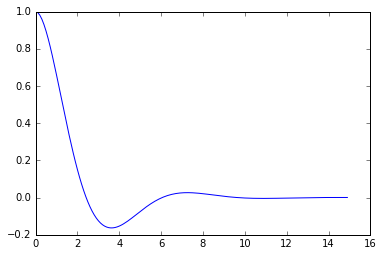

In [26]:
plt.figure()
plt.plot(ts, position, 'b')

## Turning dimensions back on

In [27]:
def wrapped_get_dimensionality_method(self):
    print('hi')
    return saved_get_dimensionality_method(self)

We can restore the saved version of `UNITS._get_dimensionality`.

In [28]:
UNITS._get_dimensionality = saved_get_dimensionality_method
UNITS._get_dimensionality

<bound method UnitRegistry._get_dimensionality of <pint.unit.UnitRegistry object at 0x7fbf235e9dd0>>

Now the units and the quantities have dimensions again.

In [29]:
UNITS.kilogram.dimensionality, UNITS.second.dimensionality, UNITS.newton.dimensionality, UNITS.meter.dimensionality

(<UnitsContainer({'[mass]': 1.0})>,
 <UnitsContainer({'[time]': 1.0})>,
 <UnitsContainer({'[length]': 1.0, '[mass]': 1.0, '[time]': -2.0})>,
 <UnitsContainer({'[length]': 1.0})>)

In [30]:
mass.dimensionality, k.dimensionality, c.dimensionality, ts.dimensionality

(<UnitsContainer({'[mass]': 1.0})>,
 <UnitsContainer({'[mass]': 1.0, '[time]': -2.0})>,
 <UnitsContainer({'[mass]': 1.0, '[time]': -1.0})>,
 <UnitsContainer({'[time]': 1.0})>)

`slope_func` still works.

In [31]:
slope_func(y_init, 0)

(<Quantity(0, 'meter / second')>, <Quantity(-1.0, 'newton / kilogram')>)

But `odeint` doesn't.

In [32]:
asol = odeint(slope_func, y_init, ts)

ValueError: setting an array element with a sequence.